# 5. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises

## 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

In [2]:
# Go to the extras folder in the course github and go to helper_functions.py, click "raw" and copy url
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-28 10:08:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-28 10:08:52 (54.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-03-28 10:08:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.253.119.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   134MB/s    in 1.2s    

2022-03-28 10:08:53 (134 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
from tensorflow.keras import layers

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [7]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [8]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         image_size=(224, 224),
                                                         label_mode="categorical",
                                                         batch_size=32)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                         image_size=(224, 224),
                                                         label_mode="categorical",
                                                         batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


train_data is of the class BatchDataset, extending tf.data.Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset


In [10]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
batch = train_data.take(1)
for x in batch.as_numpy_iterator():
  print(x[1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0.

In [12]:
len(list(batch.as_numpy_iterator())[0][1])

32

In [13]:
train_data.class_names.index("grilled_salmon")

3

In [14]:
len(list(train_data.as_numpy_iterator()))

24

In [15]:
# Filter the dataset by getting only entries with the class "grilled_salmon"
grilled_salmon_index = train_data.class_names.index("grilled_salmon")
filtered = train_data.unbatch().filter(lambda image, label: tf.equal(label[grilled_salmon_index], 1.))
# filtered = train_data.unbatch().filter(lambda x, y: y[grilled_salmon_index] == 1.)

In [16]:
len(list(filtered.as_numpy_iterator()))

75

In [17]:
for x in filtered.as_numpy_iterator():
  print(x[1])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0

In [18]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.cpkt"

# Create a ModelCheckpoint callback that saves the model's weight's only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)

In [19]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # not include last dense layer so we can use it as a feature extractor.

base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8960 - accuracy: 0.4027
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.cpkt
24/24 [==============================] - 26s 374ms/step - loss: 1.8960 - accuracy: 0.4027 - val_loss: 1.3015 - val_accuracy: 0.7270
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.1341 - accuracy: 0.7507
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.cpkt
24/24 [==============================] - 7s 284ms/step - loss: 1.1341 - accuracy: 0.7507 - val_loss: 0.9263 - val_accuracy: 0.7681
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.8213
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.cpkt
24/24 [==============================] - 7s 281ms/step - loss: 0.8374 - accuracy: 0.8213 - val_loss: 0.7526 - val_accuracy: 0.8158
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 

In [20]:
model_1.evaluate(test_data)

79/79 [==============================] - 11s 139ms/step - loss: 0.5000 - accuracy: 0.8492


[0.5000037550926208, 0.8492000102996826]

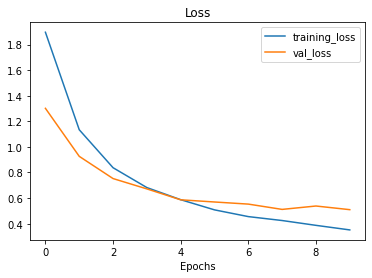

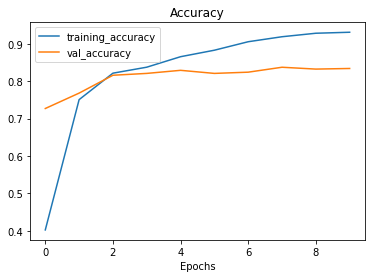

In [21]:
plot_loss_curves(history_1)

## 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [22]:
base_model.trainable = True
for layer_number, layer in enumerate(base_model.layers[:-20]):
  layer.trainable = False

In [23]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [24]:
history_1.epoch[-1]

9

In [25]:
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(0.0001), # divide learning_rate by 10 when fine tuning
                metrics=["accuracy"])

history_2 = model_1.fit(train_data,
                        epochs=20,
                        initial_epoch=history_1.epoch[-1],
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)))

Epoch 10/20
24/24 [==============================] - 18s 362ms/step - loss: 0.7674 - accuracy: 0.8347 - val_loss: 0.4945 - val_accuracy: 0.8257
Epoch 11/20
24/24 [==============================] - 7s 280ms/step - loss: 0.5173 - accuracy: 0.9213 - val_loss: 0.4425 - val_accuracy: 0.8405
Epoch 12/20
24/24 [==============================] - 7s 281ms/step - loss: 0.3663 - accuracy: 0.9520 - val_loss: 0.4354 - val_accuracy: 0.8405
Epoch 13/20
24/24 [==============================] - 7s 281ms/step - loss: 0.2986 - accuracy: 0.9653 - val_loss: 0.4321 - val_accuracy: 0.8438
Epoch 14/20
24/24 [==============================] - 7s 281ms/step - loss: 0.2532 - accuracy: 0.9653 - val_loss: 0.4566 - val_accuracy: 0.8421
Epoch 15/20
24/24 [==============================] - 7s 285ms/step - loss: 0.2044 - accuracy: 0.9773 - val_loss: 0.4141 - val_accuracy: 0.8438
Epoch 16/20
24/24 [==============================] - 7s 282ms/step - loss: 0.1726 - accuracy: 0.9787 - val_loss: 0.4426 - val_accuracy: 0.847

In [26]:
model_1.evaluate(test_data)# a bit better than feature extraction

79/79 [==============================] - 13s 157ms/step - loss: 0.4138 - accuracy: 0.8612


[0.413815438747406, 0.8611999750137329]

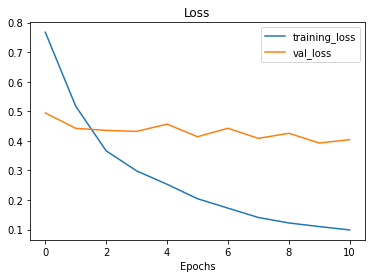

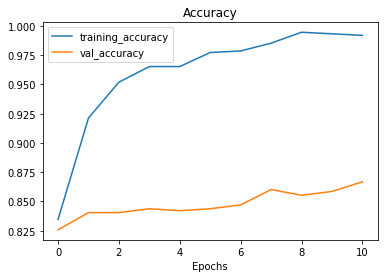

In [27]:
plot_loss_curves(history_2) # the model has been overfitted with 20 unfrozen layers

## 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [28]:
base_model.trainable = True
for layer_number, layer in enumerate(base_model.layers[:-30]):
  layer.trainable = False


In [29]:
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

history_3 = model_1.fit(train_data,
                        epochs=30,
                        initial_epoch=history_2.epoch[-1]+1,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)))

Epoch 21/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 19s 377ms/step - loss: 0.1166 - accuracy: 0.9907 - val_loss: 0.4144 - val_accuracy: 0.8536
Epoch 22/30
24/24 [==============================] - 8s 291ms/step - loss: 0.0824 - accuracy: 0.9933 - val_loss: 0.4139 - val_accuracy: 0.8651
Epoch 23/30
24/24 [==============================] - 7s 290ms/step - loss: 0.0628 - accuracy: 0.9973 - val_loss: 0.3662 - val_accuracy: 0.8717
Epoch 24/30
24/24 [==============================] - 7s 288ms/step - loss: 0.0561 - accuracy: 0.9960 - val_loss: 0.3765 - val_accuracy: 0.8651
Epoch 25/30
24/24 [==============================] - 8s 300ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.3849 - val_accuracy: 0.8602
Epoch 26/30
24/24 [==============================] - 7s 296ms/step - loss: 0.0429 - accuracy: 0.9933 - val_loss: 0.3910 - val_accuracy: 0.8651
Epoch 27/30
24/24 [==============================] - 7s 287ms/step - loss: 0.0324 - accuracy: 0.9987 - val_loss: 0.3867 - val_accuracy: 0.8684
Epoch 28/3

In [30]:
model_1.evaluate(test_data) # almost the same as before

79/79 [==============================] - 12s 142ms/step - loss: 0.4096 - accuracy: 0.8664


[0.409606397151947, 0.8664000034332275]

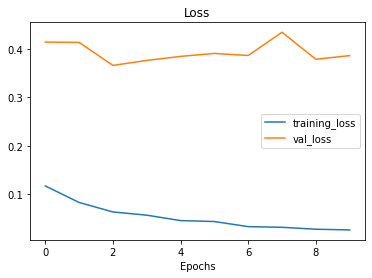

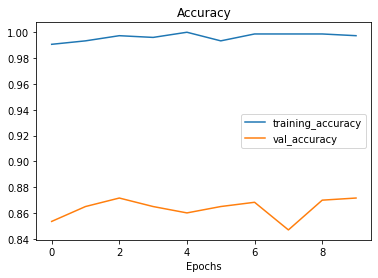

In [31]:
plot_loss_curves(history_3) # more overfitting

## 3. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [43]:
list(filtered)[0]

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[235.05612  , 230.05612  , 224.05612  ],
         [235.23979  , 230.23979  , 224.23979  ],
         [234.15816  , 229.15816  , 223.58673  ],
         ...,
         [ 12.326577 ,   7.969369 ,  11.755105 ],
         [ 14.183628 ,   8.183628 ,  12.183628 ],
         [ 10.872506 ,   4.8725066,   8.872506 ]],
 
        [[238.85204  , 233.85204  , 229.85204  ],
         [228.77042  , 223.77042  , 219.77042  ],
         [229.09694  , 224.09694  , 220.09694  ],
         ...,
         [ 10.688793 ,   6.331585 ,  10.117321 ],
         [ 14.790818 ,   9.790818 ,  13.790818 ],
         [ 14.285749 ,   9.285749 ,  13.285749 ]],
 
        [[242.28061  , 237.4949   , 233.70918  ],
         [240.12755  , 235.34183  , 231.55612  ],
         [233.69388  , 228.90816  , 225.12245  ],
         ...,
         [  9.091827 ,   6.9540863,  10.       ],
         [  7.6275487,   6.0561204,   8.841834 ],
         [ 13.418527 ,  11.847098 ,  14.632812

In [40]:
for images, labels in filtered.take(-1):
  print(labels)

tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Ten

In [44]:
len(list(filtered))

75

In [51]:
np.random.choice(len(list(filtered)))

18

In [73]:
image, label = list(filtered)[np.random.choice(len(list(filtered)))]
image, label

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[178.64285, 184.64285, 198.64285],
         [179.15083, 185.15083, 199.15083],
         [179.64285, 185.64285, 199.64285],
         ...,
         [169.84662, 177.84662, 196.84662],
         [168.43301, 176.43301, 195.43301],
         [167.64285, 175.64285, 194.64285]],
 
        [[181.92857, 187.92857, 201.92857],
         [181.92857, 187.92857, 201.92857],
         [182.24554, 188.24554, 202.24554],
         ...,
         [173.24553, 181.24553, 200.24553],
         [171.71873, 179.71873, 198.71873],
         [170.92857, 178.92857, 197.92857]],
 
        [[183.63553, 189.63553, 203.63553],
         [184.21428, 190.21428, 204.21428],
         [184.28221, 190.28221, 204.28221],
         ...,
         [175.74553, 183.74553, 202.74553],
         [174.21873, 182.21873, 201.21873],
         [173.42857, 181.42857, 200.42857]],
 
        ...,
 
        [[160.78574, 165.78574, 184.78574],
         [159.99556, 164.99556, 183.99556]

In [101]:
predict = model_1.predict(tf.expand_dims(image, 0))
print(predict)
print(predict.argmax())

[[3.5317030e-04 9.9965282e-06 9.1152986e-05 9.9146175e-01 1.9283380e-04
  3.4887820e-05 1.7054363e-05 4.6292738e-05 7.7330587e-03 5.9746526e-05]]
3


In [115]:
def view_random_prediction(trained_model, dataset, target_class):
  """
  Plot a random image from dataset pertainign to target class and its prediction
  with the trained_model
  """
  class_names = dataset.class_names
  class_index = class_names.index(target_class)
  filtered_dataset = dataset.unbatch().filter(lambda image, label: tf.equal(label[class_index], 1.))
  filtered_list = list(filtered_dataset)
  random_index = np.random.choice(len(filtered_list))
  image, label = filtered_list[random_index]
  plt.imshow(image/255)
  plt.axis("off")
  prediction = trained_model.predict(tf.expand_dims(image, 0))
  predicted_class_index = prediction.argmax()
  prediction_prob = prediction.max()
  prob_txt = "{:.2f}".format(prediction_prob*100)
  plt.title(f"True class: {target_class}, predicted class: {class_names[predicted_class_index]} probability {prob_txt} %")


In [103]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

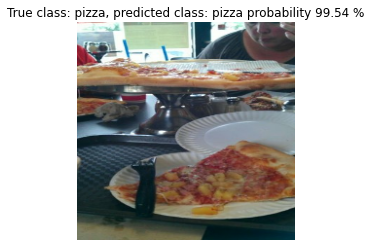

In [117]:
view_random_prediction(model_1, train_data, "pizza")

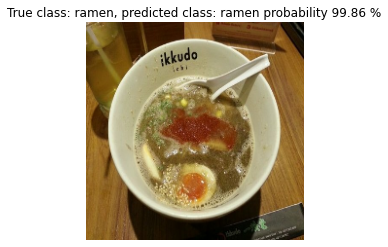

In [118]:
view_random_prediction(model_1, train_data, "ramen")

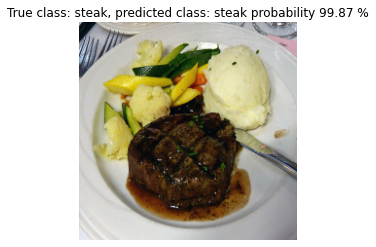

In [119]:
view_random_prediction(model_1, train_data, "steak")

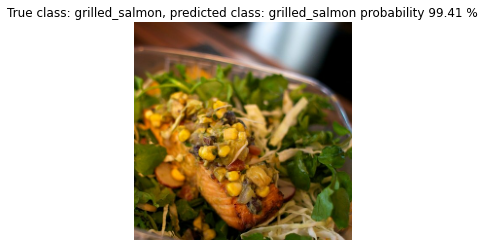

In [120]:
view_random_prediction(model_1, train_data, "grilled_salmon")